# Sequence Alignment with Genetic Algorithm + Qwen2.5-1.5B-Instruct

In [1]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 29.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, random
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Align import substitution_matrices as sm

In [3]:
import Bio
print(Bio.__version__)

1.85


In [4]:
import torch, os
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("device:", torch.cuda.get_device_name(0))
else:
    print("→ In Kaggle UI, set Accelerator=GPU and re-run the kernel.")

torch: 2.1.2
cuda available: True
device: Tesla T4


In [5]:
# === GPU-accelerated fitness (PyTorch) — paste after SUBST/seqs/max_len ===
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# ----------------------------
# Config
# ----------------------------
FASTA_PATH = "/kaggle/input/sequence-alignment-bioinformatics-dataset/proteins.fasta"
PAM_PATH   = "/kaggle/input/sequence-alignment-bioinformatics-dataset/PAM250.txt"  # optional fallback
OUT_DIR    = "/kaggle/working/alignments"
os.makedirs(OUT_DIR, exist_ok=True)

SEED             = 7
N_POP            = 80          # was 50
N_GENERATIONS    = 40          # was 10 — gives GA time to improve
ELITE_K          = 6
N_SELECT         = 60
TOURNAMENT_K     = 3           # before 5
IMMIGRANTS       = 8           # random new individuals per generation

CROSSOVER_RATE   = 0.85
MUTATION_RATE    = 0.35        # higher; we accept only if fitness improves (see local refine)
BLOCK_SHIFT_P    = 0.5         # among mutations, probability to do block shift (else single slide)

USE_AFFINE_GAPS  = True
GAP_OPEN         = -10
GAP_EXTEND       = -1
FLAT_GAP_PENALTY = -1          # ignored if affine on

random.seed(SEED)
np.random.seed(SEED)

In [21]:
# ----------------------------
# Substitution matrix (modern API)
# ----------------------------
def build_subst_matrix():
    # Try PAM250 first
    try:
        arr = sm.load("PAM250")
        mat = pd.DataFrame(np.array(arr), index=list(arr.alphabet), columns=list(arr.alphabet)).astype(int)
        return mat, "biopython:PAM250"
    except Exception:
        pass
    # Fallback to dataset file
    try:
        df = pd.read_csv(PAM_PATH, delim_whitespace=True, comment="#")
        df = df.rename(columns={df.columns[0]: "AA"}).set_index("AA")
        df = df.apply(pd.to_numeric, errors="coerce").fillna(-4).astype(int)
        if "*" in df.columns: df = df.drop(columns=["*"])
        if "*" in df.index:   df = df.drop(index=["*"])
        return df, "file:PAM250.txt"
    except Exception:
        pass
    # Last resort: BLOSUM62
    arr = sm.load("BLOSUM62")
    mat = pd.DataFrame(np.array(arr), index=list(arr.alphabet), columns=list(arr.alphabet)).astype(int)
    return mat, "biopython:BLOSUM62"

SUBST, SRC = build_subst_matrix()
AA_SET = set(SUBST.index)
print("Substitution matrix source:", SRC)

Substitution matrix source: biopython:PAM250


In [22]:
# ----------------------------
# Data
# ----------------------------
records = list(SeqIO.parse(FASTA_PATH, "fasta"))
seq_ids = [r.id for r in records]
seqs    = [str(r.seq) for r in records]
# guard unknown letters -> treat as 'X' if present in matrix else drop
def sanitize(s):
    return ''.join(ch if ch in AA_SET else 'X' if 'X' in AA_SET else ch for ch in s)
seqs = [sanitize(s) for s in seqs]

n_seq   = len(seqs)
max_len = max(len(s) for s in seqs)

# Genetic Algorithm

In [23]:
# ----------------------------
# New with GPU
# ----------------------------
# Map AA letters to indices in the same order as SUBST rows/cols
AA_LIST = list(SUBST.index)
aa_to_ix = {aa: i for i, aa in enumerate(AA_LIST)}
UNK_IX = aa_to_ix.get("X", 0)  # fallback index if any unknowns remain

# Put substitution matrix on GPU once
SUBST_T = torch.tensor(SUBST.values, dtype=torch.int32, device=DEVICE)

# Precompute all (i<j) pairs for sum-of-pairs
PAIR_IJ = [(i, j) for i in range(n_seq) for j in range(i + 1, n_seq)]
PAIR_I = torch.tensor([i for i, _ in PAIR_IJ], device=DEVICE, dtype=torch.long)
PAIR_J = torch.tensor([j for _, j in PAIR_IJ], device=DEVICE, dtype=torch.long)

def encode_chrom_to_tensor(chrom):
    """
    chrom: list[str] of length n_seq (all same length == max_len)
    returns: (n_seq, L) int16 tensor; -1 for gaps, else AA index.
    """
    mat = []
    for line in chrom:
        row = [(-1 if ch == '-' else aa_to_ix.get(ch, UNK_IX)) for ch in line]
        mat.append(row)
    return torch.tensor(mat, dtype=torch.int16, device=DEVICE)

@torch.inference_mode()
def fitness_gpu(chrom):
    """
    Vectorized sum-of-pairs with affine gaps on GPU:
      - Substitution part from SUBST_T when both residues present
      - Affine gaps counted separately for i-only and j-only gaps
      - Columns with double gaps incur no penalty (matches your CPU logic)
    """
    A  = encode_chrom_to_tensor(chrom)         # (n_seq, L) with -1 for gaps
    Ai = A.index_select(0, PAIR_I)             # (num_pairs, L)
    Aj = A.index_select(0, PAIR_J)

    # Substitution scores where both positions are residues
    both = (Ai >= 0) & (Aj >= 0)
    sub  = SUBST_T[Ai.clamp_min(0).long(), Aj.clamp_min(0).long()].to(torch.int32)
    sub  = sub * both.to(torch.int32)
    sub_sum = sub.sum(dim=1)                   # per pair

    # Gap masks for affine penalties (i-gap only / j-gap only)
    g1 = (Ai == -1) & (Aj >= 0)
    g2 = (Aj == -1) & (Ai >= 0)

    def affine_penalty(gmask):
        # gap_open charged when a run starts; gap_extend charged for the rest of the run
        if gmask.size(1) == 0:
            return torch.zeros(gmask.size(0), dtype=torch.int32, device=DEVICE)
        opens0 = gmask[:, 0].to(torch.int32)
        trans  = (gmask[:, 1:] & (~gmask[:, :-1])).to(torch.int32).sum(dim=1)
        opens  = opens0 + trans
        extends = gmask.to(torch.int32).sum(dim=1) - opens
        return opens * GAP_OPEN + extends * GAP_EXTEND

    if USE_AFFINE_GAPS:
        gap_pen = affine_penalty(g1) + affine_penalty(g2)
    else:
        # flat penalty fallback
        gap_pen = ((g1 | g2).to(torch.int32).sum(dim=1)) * FLAT_GAP_PENALTY

    total_pairs = sub_sum + gap_pen
    return int(total_pairs.sum().item())

# ------- keep your original CPU fitness for checking (unchanged) -------
def fitness_py(chrom):
    total = 0
    for i in range(n_seq):
        si = chrom[i]
        for j in range(i + 1, n_seq):
            total += (sp_score_pair_affine(si, chrom[j]) if USE_AFFINE_GAPS
                      else sp_score_pair_flat(si, chrom[j]))
    return total

# ------- OVERRIDE: make GA use the GPU scorer -------
def fitness(chrom):
    return fitness_gpu(chrom)

print("GPU fitness ready on", DEVICE)

GPU fitness ready on cuda


In [24]:
# ----------------------------
# Genetic Algorithm ops with GPU
# ----------------------------

#  ------- Helpers  -------
def initial_individual():
    aligned = []
    for s in seqs:
        g = list(s)
        need = max_len - len(g)
        while need > 0:
            p = random.randint(0, len(g))
            r = random.randint(1, need)
            g[p:p] = ['-'] * r
            need -= r
        aligned.append(''.join(g))
    return aligned

def initial_population(n):
    return [initial_individual() for _ in range(n)]

# Sum-of-Pairs score for a pair with affine or flat gaps
def sp_score_pair_affine(s1, s2):
    score = 0
    in_gap = 0  # 0: none, 1: gap in s1, 2: gap in s2
    for a, b in zip(s1, s2):
        if a == '-' and b == '-':
            # do not double-penalize both-gap columns
            continue
        if a == '-' or b == '-':
            if in_gap == 0:
                score += GAP_OPEN
                in_gap = 1 if a == '-' else 2
            else:
                # continuing the same gap?
                if (in_gap == 1 and a == '-') or (in_gap == 2 and b == '-'):
                    score += GAP_EXTEND
                else:
                    # switched which sequence has the gap -> open a new one
                    score += GAP_OPEN
                    in_gap = 1 if a == '-' else 2
        else:
            in_gap = 0
            try:
                score += int(SUBST.loc[a, b])
            except Exception:
                score += -4
    return score

def sp_score_pair_flat(s1, s2):
    score = 0
    for a, b in zip(s1, s2):
        if a == '-' and b == '-':
            continue
        if a == '-' or b == '-':
            score += FLAT_GAP_PENALTY
        else:
            try:
                score += int(SUBST.loc[a, b])
            except Exception:
                score += -4
    return score

PAIR_SCORE = sp_score_pair_affine if USE_AFFINE_GAPS else sp_score_pair_flat

# # fitness changed to GPU
# def fitness(chrom):
#     total = 0
#     for i in range(n_seq):
#         si = chrom[i]
#         for j in range(i+1, n_seq):
#             total += PAIR_SCORE(si, chrom[j])
#     return total

#  ------- Selection: tournament -------
def tournament_selection(pop, n_select, k=TOURNAMENT_K):
    selected = []
    for _ in range(n_select):
        contestants = random.sample(pop, k)
        best = max(contestants, key=fitness)
        selected.append(best)
    return selected

def pick_parents(selected):
    return random.choice(selected), random.choice(selected)

# ------- Crossover: residue-count-preserving one-point (your logic), with chance to do two-point -------
def crossover(p1, p2, length=max_len, rate=CROSSOVER_RATE):
    if random.random() > rate:
        return [x[:] for x in random.choice([p1, p2])]

    # 50% single-point, 50% two-point
    if random.random() < 0.5:
        cuts = [random.randint(2, length-2)]
    else:
        a, b = sorted(random.sample(range(2, length-2), 2))
        cuts = [a, b]

    child = []
    for s in range(n_seq):
        # build by preserving residue order; decide which columns come from p1 vs p2
        # mask: segments alternate between parents starting with p1
        segments = []
        prev = 0
        parent_flag = 0  # 0->p1, 1->p2
        for c in cuts + [length]:
            segments.append((prev, c, parent_flag))
            parent_flag ^= 1
            prev = c

        # Count residues placed so far from chosen parent segments
        placed = 0
        seq1, seq2 = p1[s], p2[s]
        # collapse residues for both parents
        res1 = [ch for ch in seq1 if ch != '-']
        res2 = [ch for ch in seq2 if ch != '-']

        out = []
        # We reconstruct column-by-column choosing gaps from the parent segments but preserving global residue order:
        res_idx1 = res_idx2 = 0
        for start, end, flag in segments:
            src = seq1 if flag == 0 else seq2
            # copy that column window's gap pattern but pull letters from the corresponding residue stream
            for col in range(start, end):
                if src[col] == '-':
                    out.append('-')
                else:
                    if flag == 0:
                        out.append(res1[res_idx1]); res_idx1 += 1
                    else:
                        out.append(res2[res_idx2]); res_idx2 += 1

        # Fix length (rare drift from uneven residue counts in segments)
        if len(out) < length:
            out = ['-']*(length-len(out)) + out
        elif len(out) > length:
            # trim leading gaps
            need = len(out) - length
            j = 0
            while need and j < len(out):
                if out[j] == '-':
                    out.pop(j)
                    need -= 1
                else:
                    j += 1
            out = out[:length]
        child.append(''.join(out))
    return child


# ------- Mutations -------
def mutate_slide(line, left=False):
    # slide residue across a single adjacent gap
    chars = list(line)
    rng = range(1, len(chars)-1) if left else range(len(chars)-1)
    for i in rng:
        i0 = i
        i1 = i-1 if left else i+1
        if left:
            if chars[i] == '-' and chars[i1] != '-':
                chars[i], chars[i1] = chars[i1], chars[i]
                return ''.join(chars)
        else:
            if chars[i] != '-' and chars[i1] == '-':
                chars[i], chars[i1] = chars[i1], chars[i]
                return ''.join(chars)
    return line

def mutate_block_shift(line, max_block=4, direction=None):
    # shift a residue block over adjacent gap block (small k)
    L = len(line)
    chars = list(line)
    # pick a start where we have residues followed by gaps or vice versa
    for _ in range(16):
        i = random.randint(0, L-2)
        # choose direction if not given
        dir_right = (direction is None and random.random()<0.5) or (direction == "right")
        if dir_right:
            # look for residue block 'AAA' followed by gap block '---'
            if chars[i] != '-':
                # residue block length
                r = 1
                while i+r < L and chars[i+r] != '-' and r < max_block:
                    r += 1
                j = i + r
                if j < L and chars[j] == '-':
                    g = 1
                    while j+g < L and chars[j+g] == '-' and g < max_block:
                        g += 1
                    # swap one residue to the right over one gap
                    chars[i+r-1], chars[j] = chars[j], chars[i+r-1]
                    return ''.join(chars)
        else:
            # look for gap block then residue block, shift one residue left
            if chars[i] == '-' and chars[i+1] != '-':
                chars[i], chars[i+1] = chars[i+1], chars[i]
                return ''.join(chars)
    return line

def try_improving_mutation(chrom):
    """Apply one random mutation and keep it only if fitness improves."""
    base_f = fitness(chrom)
    mutated = chrom[:]
    s = random.randrange(n_seq)
    if random.random() < BLOCK_SHIFT_P:
        mutated[s] = mutate_block_shift(mutated[s])
    else:
        if random.random() < 0.5:
            mutated[s] = mutate_slide(mutated[s], left=False)
        else:
            mutated[s] = mutate_slide(mutated[s], left=True)
    if mutated[s] == chrom[s]:
        return chrom  # nothing changed
    new_f = fitness(mutated)
    return mutated if new_f > base_f else chrom

def mutate(chrom, rate=MUTATION_RATE, tries=2):
    out = chrom[:]
    if random.random() > rate:
        return out
    for _ in range(tries):
        out2 = try_improving_mutation(out)
        if out2 is out:
            break
        out = out2
    return out

# # Evolution Old
# def evolve(pop):
#     # Elitism
#     pop = sorted(pop, key=fitness, reverse=True)
#     next_pop = pop[:ELITE_K]

#     # Selection
#     selected = tournament_selection(pop, N_SELECT, TOURNAMENT_K)

#     # Reproduction
#     children = []
#     for _ in range((N_POP - ELITE_K - IMMIGRANTS)):
#         p1, p2 = random.choice(selected), random.choice(selected)
#         child = crossover(p1, p2)
#         child = mutate(child)
#         children.append(child)

#     # Random immigrants
#     immigrants = [initial_individual() for _ in range(IMMIGRANTS)]

#     next_pop.extend(children)
#     next_pop.extend(immigrants)

#     # Trim to N_POP with elitism preserved
#     next_pop = sorted(next_pop, key=fitness, reverse=True)[:N_POP]
#     return next_pop


## ------- Evolution New compatible with GPU version (avoiding recomputing fitness) -------
def evaluate_population(pop):
    # one GPU pass per individual; cached for this generation
    return np.array([fitness(ind) for ind in pop], dtype=np.int32)

def tournament_selection_fast(pop, fits, n_select, k=TOURNAMENT_K):
    selected = []
    N = len(pop)
    for _ in range(n_select):
        idxs = np.random.randint(0, N, size=k)
        best_idx = idxs[np.argmax(fits[idxs])]
        selected.append(pop[best_idx])
    return selected

def evolve_fast(pop):
    # ---- evaluate once ----
    fits = evaluate_population(pop)
    order = np.argsort(fits)[::-1]

    # Elitism
    next_pop = [pop[i] for i in order[:ELITE_K]]

    # Selection (by indices + cached fitness)
    selected = tournament_selection_fast(pop, fits, N_SELECT, TOURNAMENT_K)

    # Reproduction
    children = []
    for _ in range(N_POP - ELITE_K - IMMIGRANTS):
        p1, p2 = random.choice(selected), random.choice(selected)
        child = crossover(p1, p2)
        child = mutate(child)
        children.append(child)

    # Immigrants
    immigrants = [initial_individual() for _ in range(IMMIGRANTS)]

    # Collect and evaluate once
    candidates = next_pop + children + immigrants
    cand_fits = evaluate_population(candidates)
    keep = np.argsort(cand_fits)[::-1][:N_POP]
    return [candidates[i] for i in keep]

In [25]:
# ----------------------------
# Run GA for GPU
# ----------------------------
population = initial_population(N_POP)
for gen in range(1, N_GENERATIONS+1):
    population = evolve_fast(population)
    if gen % 5 == 0 or gen == 1:
        print(f"Gen {gen:02d} | best fitness: {fitness(population[0])}")

best = population[0]
print("\nBest alignment (first 120 cols):")
for sid, line in zip(seq_ids, best):
    print(f"{sid:<15} {line[:120]}")
print("\nBest fitness:", fitness(best))

Gen 01 | best fitness: -1423
Gen 05 | best fitness: 251
Gen 10 | best fitness: 1585
Gen 15 | best fitness: 2383
Gen 20 | best fitness: 2724
Gen 25 | best fitness: 2843
Gen 30 | best fitness: 2843
Gen 35 | best fitness: 2969
Gen 40 | best fitness: 3314

Best alignment (first 120 cols):
human-kiss1     MNSMNSMNSLVSWQLLLFLCATMNMMNSMNSMNSMNSLVSWQLLLFLCATMNMMNSMNSLVSWQLLLMNSMNSLVSWQLLLFLCATMNMMNFMNSMNSMNSLVSWQLLLFLCATMNMMMN
mouse-kiss1     MISMISMISMASWQLLLLLCVAMIMMISMISMISMISMASWQLLLLLCVAMIMMISMISMASWQLLLMISMISMASWQLLLLLC-VAMIMMLMISMISMISMASWQLLLLLCVAMIMMMI
zebrafish-kiss1 MMLMMLMMLLTVILML-SVARVHMMMMLMMLMMLMMLLTVILMLS-----VARVHMMMMLMMLLTVIMMLMMLLTVILMLSVARVHMMMMLLMMLMMLMMLLTVILMLSVARVHMMMMML
frog-kiss1      MSSMSSMSSLCLFLFLLGIHLGMSMMSSMSSMSSMSSLCLFLFLLGIHLGMSMMSSMSSLCLFLFLLMSSMSSLCLFLFLLGIHLGMSMMSGMSSMSSMSSLC----LFLFLLGIHLGMS
opposum-kiss1   MRSMRSMRSSVYWQLLLLLSVSMRMMRSMRSMRSMRSSVYWQLLLLLSVSMRMMRSMRSSVYWQLLLMRSMRSSVYWQLLLLLSVSMRMMRLMRSMRSMRSSVYWQLLLLLSVSMRMMMR
zebrafish-kiss2 M------------

In [21]:
# # ----------------------------
# # Run GA w/o GPU
# # ----------------------------
# population = initial_population(N_POP)
# best_trace = []
# for gen in range(1, N_GENERATIONS+1):
#     population = evolve(population)
#     best_fit = fitness(population[0])
#     best_trace.append(best_fit)
#     if gen % 5 == 0 or gen == 1:
#         print(f"Gen {gen:02d} | best fitness: {best_fit}")

# best = population[0]
# print("\nBest alignment (first 120 cols):")
# for sid, line in zip(seq_ids, best):
#     print(f"{sid:<15} {line[:120]}")
# print("\nBest fitness:", fitness(best))

Gen 01 | best fitness: -1410
Gen 05 | best fitness: 319
Gen 10 | best fitness: 2357
Gen 15 | best fitness: 3864
Gen 20 | best fitness: 4170

Best alignment (first 120 cols):
human-kiss1     MNSLVSWQLLLFMNSLVSWQLLLFMNMNSLMMNSLVSWQLLLFMMNMMNMNMNMNSLMNSLVSWQLLMMNSLVSWQLLLMNSLMMNMNSLMNSLVSWQLLMMNSMNSLVSWQLLLFMNSL
mouse-kiss1     MISMASWQLLLLMISMASWQLLLLMIMISMMMISMASWQLLLLMMIMMIMIMIMISMMISMASWQLLMMISMASWQLLLMISMMMIMISMMISMASWQLLMMISMISMASWQLLLLMISM
zebrafish-kiss1 MMLLTVILMLSVMMLLTVILMLSVMMMMLLMMMLLTVILMLSVMMMMMMMM--------------------------------MMMMLLM-MLLTVILMLMMMMMML----LMMLLTVIL
frog-kiss1      MSSLCLFLFLLGMSSLCLFLFLLGMSMSSLMMSSLCLFLFLLGMMSMMSMSMSMSSLMSSLCLFLFLMMSSLCLF-LFLLMSSMMSMSSLMSSLCLFLFLMMSSMSSLCLFLFLLGMSSL
opposum-kiss1   MRSSVYWQLLLLMRSSVYWQLLLLMRMRSSMMRSSVYWQLLLLMMRMMRMRMRMRSSMRSSVYWQLLMMRSSVYWQLLLMRSSMMRMRSSMRSSVYWQLLMMRSMRSSVYWQLLLLMRSS
zebrafish-kiss2 MNTRALILFMSAMNTRALILFMSAMNMNTRMMNTRALILFMSAMMNMMNMNMNMNTRMNTRALILFMMMNTRALILFMSMNTRMMNMNTRMNTRALILFMMMN---TMNTRALILFMSAM
frog

In [26]:
# ----------------------------
# Save outputs
# ----------------------------
fasta_out = os.path.join(OUT_DIR, "ga_best.fasta")
with open(fasta_out, "w") as f:
    for sid, line in zip(seq_ids, best):
        f.write(f">{sid}\n{line}\n")

clustal_out = os.path.join(OUT_DIR, "ga_best.aln")
with open(clustal_out, "w") as f:
    f.write("CLUSTAL GA-MSA-v2\n\n")
    block = 60
    L = len(best[0])
    for start in range(0, L, block):
        for sid, line in zip(seq_ids, best):
            f.write(f"{sid:<15} {line[start:start+block]}\n")
        f.write("\n")

print(f"\nSaved: {fasta_out}")
print(f"Saved: {clustal_out}")


Saved: /kaggle/working/alignments/ga_best.fasta
Saved: /kaggle/working/alignments/ga_best.aln


In [27]:
# === Metrics + Auto-summary for GA alignment (and optional others) ===
import os, math
import numpy as np
from collections import Counter
from Bio import AlignIO

ALIGN_DIR = "/kaggle/working/alignments"
CANDIDATES = {
    "GA": os.path.join(ALIGN_DIR, "ga_best.aln"),          # produced by your GA cell
    # add these later if you have them:
    # "Clustal": "/kaggle/input/.../clustal.aln",
    # "MUSCLE":  "/kaggle/input/.../muscle.aln",
}

def load_aln(path):
    return AlignIO.read(path, "clustal")

def shannon_entropy(col):
    aa = [c for c in col if c != '-']
    if not aa:
        return 2.0
    freq = np.array(list(Counter(aa).values()), float)
    p = freq / freq.sum()
    return -np.sum(p * np.log2(p))

def column_entropies(aln):
    L = aln.get_alignment_length()
    return np.array([shannon_entropy(aln[:, i]) for i in range(L)])

def gap_density(aln):
    L = aln.get_alignment_length()
    return np.array([sum(1 for c in aln[:, i] if c == '-') / len(aln) for i in range(L)])

def pairwise_identity(a, b):
    match = total = 0
    for x, y in zip(a, b):
        if x == '-' or y == '-': 
            continue
        total += 1
        match += (x == y)
    return 0.0 if total == 0 else 100.0 * match / total

def identities_matrix(aln):
    n = len(aln)
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            pid = pairwise_identity(str(aln[i].seq), str(aln[j].seq))
            M[i, j] = M[j, i] = pid
    return M

def ranges_from_indices(idxs):
    if idxs.size == 0: 
        return []
    ranges = []
    start = prev = int(idxs[0])
    for i in map(int, idxs[1:]):
        if i == prev + 1:
            prev = i
        else:
            ranges.append((start, prev))
            start = prev = i
    ranges.append((start, prev))
    return ranges

def summarize_alignment(name, aln, entropy_thr=0.4, min_block_len=5, gap_thr=0.4):
    L = aln.get_alignment_length()
    ents = column_entropies(aln)
    gaps = gap_density(aln)
    M = identities_matrix(aln)
    # conserved blocks
    conserved_idxs = np.where(ents <= entropy_thr)[0]
    blocks = [(s, e) for (s, e) in ranges_from_indices(conserved_idxs) if (e - s + 1) >= min_block_len]
    # gap clusters
    gap_idxs = np.where(gaps >= gap_thr)[0]
    gap_blocks = [(s, e) for (s, e) in ranges_from_indices(gap_idxs) if (e - s + 1) >= 3]

    # identity stats
    tri = np.triu_indices_from(M, 1)
    mean_pid = float(M[tri].mean()) if M[tri].size else 0.0
    min_pid  = float(M[tri].min())  if M[tri].size else 0.0
    max_pid  = float(M[tri].max())  if M[tri].size else 0.0

    # nearest/farthest pairs
    def idx_to_pairs(val):
        idxs = np.where(M == val)
        pairs = [(int(i), int(j)) for i, j in zip(idxs[0], idxs[1]) if i < j]
        return pairs

    nearest_pairs  = idx_to_pairs(max_pid)
    farthest_pairs = idx_to_pairs(min_pid)

    print(f"\n=== {name} ===")
    print(f"Sequences: {len(aln)} | Columns: {L}")
    print(f"Median entropy: {float(np.median(ents)):.3f} (lower = more conserved)")
    print(f"Mean pairwise identity: {mean_pid:.1f}%  (min {min_pid:.1f}%, max {max_pid:.1f}%)")
    print(f"Conserved blocks (entropy ≤ {entropy_thr}, len ≥ {min_block_len}): {blocks[:6]}{' ...' if len(blocks)>6 else ''}")
    print(f"Gap clusters (gap ≥ {int(gap_thr*100)}% of seqs, len ≥ 3): {gap_blocks[:6]}{' ...' if len(gap_blocks)>6 else ''}")

    # Auto-answers you can paste in a report
    print("\n-- Auto-summary --")
    print("Conserved regions:", ", ".join([f"{s}-{e}" for s,e in blocks]) if blocks else "none clear by threshold.")
    print("Gap locations:",     ", ".join([f"{s}-{e}" for s,e in gap_blocks]) if gap_blocks else "no large clusters.")
    # nearest/farthest by indices → map to IDs
    ids = [r.id for r in aln]
    np.set_printoptions(precision=1, suppress=True)
    if nearest_pairs:
        pairs_txt = ", ".join([f"{ids[i]}–{ids[j]} ({M[i,j]:.1f}%)" for i,j in nearest_pairs[:3]])
        print("Closest pairs:", pairs_txt)
    if farthest_pairs:
        pairs_txt = ", ".join([f"{ids[i]}–{ids[j]} ({M[i,j]:.1f}%)" for i,j in farthest_pairs[:3]])
        print("Most divergent pairs:", pairs_txt)

for name, path in CANDIDATES.items():
    if os.path.exists(path):
        aln = load_aln(path)
        summarize_alignment(name, aln)
    else:
        print(f"{name}: file not found at {path}")



=== GA ===
Sequences: 7 | Columns: 149
Median entropy: 1.557 (lower = more conserved)
Mean pairwise identity: 34.1%  (min 16.0%, max 64.3%)
Conserved blocks (entropy ≤ 0.4, len ≥ 5): []
Gap clusters (gap ≥ 40% of seqs, len ≥ 3): []

-- Auto-summary --
Conserved regions: none clear by threshold.
Gap locations: no large clusters.
Closest pairs: human-kiss1–mouse-kiss1 (64.3%)
Most divergent pairs: opposum-kiss1–zebrafish-kiss2 (16.0%)


# Qwen2.5-1.5B-Instruct

In [28]:
!pip -q install -U llama-cpp-python

In [60]:
# -------- Paths --------
GA_ALN = "/kaggle/working/alignments/ga_best.aln"
# >>>> CHANGE THIS to your attached GGUF model path (Add Data -> your GGUF dataset)
# Examples:
# MODEL_PATH = "/kaggle/input/qwen25-15b-instruct-gguf/Qwen2.5-1.5B-Instruct-Q4_K_M.gguf"
# MODEL_PATH = "/kaggle/input/llama-32-1b-instruct-gguf/Llama-3.2-1B-Instruct-Q4_K_M.gguf"
# MODEL_PATH = "/kaggle/input/phi-3-mini-gguf/Phi-3-mini-4k-instruct-Q4_K_M.gguf"

# -------- Build prompt from GA alignment + metrics --------
aln = load_aln(GA_ALN)
n = len(aln); L = aln.get_alignment_length()
ents = column_entropies(aln)
gaps = gap_density(aln)
M = identities_matrix(aln)
tri = np.triu_indices_from(M,1)
mean_pid = float(M[tri].mean()); min_pid=float(M[tri].min()); max_pid=float(M[tri].max())
ids = [r.id for r in aln]
nearest = [(ids[i], ids[j], M[i,j]) for i in range(n) for j in range(i+1,n) if M[i,j]==max_pid]
farthest= [(ids[i], ids[j], M[i,j]) for i in range(n) for j in range(i+1,n) if M[i,j]==min_pid]
ga_text = open(GA_ALN,"r",encoding="utf-8").read()

def fmt_pairs(pairs):
    return "—" if not pairs else ", ".join([f"{a}–{b} ({p:.1f}%)" for a,b,p in pairs])

In [61]:
prompt = f"""
You are a bioinformatics TA. Analyze this multiple sequence alignment (CLUSTAL format) and answer the assignment bullets.
Return ONLY valid JSON with this schema:

{{
  "conserved_regions": [{{"range":"start-end","note":"short note"}}],
  "gaps": [{{"range":"start-end","sequences":["id1","id2"],"pattern":"one|many"}}],
  "similarity": {{
      "closest": [{{"pair":"idA-idB","pid":63.8}}],
      "most_divergent": [{{"pair":"idC-idD","pid":21.9}}]
  }},
  "summary": "2-4 concise sentences grounded in the alignment"
}}

Answer these exactly:
- Are there conserved regions? (0-based ranges for blocks ≥5 columns; brief notes)
- Are there gaps, and if so, where are they placed (what causes them, one sequence or many)?
- How similar are the various proteins overall? (closest & most divergent pairs)

Use only evidence from the alignment; do not speculate motifs.

Context (computed):
- Sequences: {n} | Columns: {L}
- Median entropy: {float(np.median(ents)):.3f}
- Mean pairwise identity: {mean_pid:.1f}% (min {min_pid:.1f}%, max {max_pid:.1f}%)
- Closest pair(s): {fmt_pairs(nearest)}
- Most divergent pair(s): {fmt_pairs(farthest)}

ALIGNMENT:
"""

In [62]:
from llama_cpp import Llama
import os

MODEL_PATH = "/kaggle/input/qwen2.5/gguf/1.5b-instruct/1/qwen2.5-1.5b-instruct-q4_k_m.gguf"
use_gpu = bool(os.environ.get("CUDA_VISIBLE_DEVICES"))

llm = Llama(
    model_path=MODEL_PATH,
    n_ctx=8192,                 # increase if needed
    n_threads=8,                # adjust for CPU budget
    n_gpu_layers=40 if use_gpu else 0,   # 0 = CPU-only
    logits_all=False,
)

# If your prompt is long, you can also use streaming=False to simplify output handling
resp = llm.create_chat_completion(
    messages=[{"role": "user", "content": prompt}],
    temperature=0.2,
    max_tokens=700,
    repeat_penalty=1.05,
)
print(resp["choices"][0]["message"]["content"])

llama_model_loader: loaded meta data with 26 key-value pairs and 339 tensors from /kaggle/input/qwen2.5/gguf/1.5b-instruct/1/qwen2.5-1.5b-instruct-q4_k_m.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = qwen2.5-1.5b-instruct
llama_model_loader: - kv   3:                            general.version str              = v0.1
llama_model_loader: - kv   4:                           general.finetune str              = qwen2.5-1.5b-instruct
llama_model_loader: - kv   5:                         general.size_label str              = 1.8B
llama_model_loader: - kv   6:                          qwen2.block_count u32              = 28
lla

```json
{
  "conserved_regions": [
    {
      "range": "1-149",
      "note": "The alignment is complete, indicating no conserved regions."
    }
  ],
  "gaps": [
    {
      "range": "2-30",
      "sequences": ["human", "mouse"],
      "pattern": "one"
    },
    {
      "range": "41-65",
      "sequences": ["human", "mouse"],
      "pattern": "many"
    }
  ],
  "similarity": {
    "closest": [
      {
        "pair": "human-kiss1-mouse-kiss1",
        "pid": 64.3
      }
    ],
    "most_divergent": [
      {
        "pair": "opossum-kiss1-zebrafish-kiss2",
        "pid": 16.0
      }
    ]
  },
  "summary": "The alignment is complete, with no conserved regions. There are gaps at positions 2-30 and 41-65 due to differences in sequences. The closest pair of proteins is human-kiss1-mouse-kiss1 with a similarity of 64.3%, while the most divergent pair is opossum-kiss1-zebrafish-kiss2 with a divergence of 16.0%."
}
```


# Results Visualization

In [51]:
# === VISUALS for GA alignment (no API) ===
import os, numpy as np, matplotlib.pyplot as plt
from collections import Counter
from Bio import AlignIO
from Bio.Align import AlignInfo

ALIGN_PATH = "/kaggle/working/alignments/ga_best.aln"
os.makedirs("/kaggle/working/figures", exist_ok=True)
os.makedirs("/kaggle/working/tables", exist_ok=True)
os.makedirs("/kaggle/working/results/reports", exist_ok=True)

aln = AlignIO.read(ALIGN_PATH, "clustal")
ids = [r.id for r in aln]
n = len(aln); L = aln.get_alignment_length()

def shannon_entropy(col):
    aa = [c for c in col if c != '-']
    if not aa: return 2.0
    cnt = np.array(list(Counter(aa).values()), float)
    p = cnt / cnt.sum()
    return float(-np.sum(p*np.log2(p)))

def gap_density(i): 
    return sum(c=='-' for c in aln[:, i]) / n

def pid(a, b):
    m=t=0
    for x,y in zip(a,b):
        if x=='-' or y=='-': continue
        t+=1; m+=(x==y)
    return 0.0 if t==0 else 100.0*m/t

In [56]:
from IPython.display import display, Image
SHOW = True  # set False to skip inline display

import warnings 
warnings.filterwarnings('ignore')

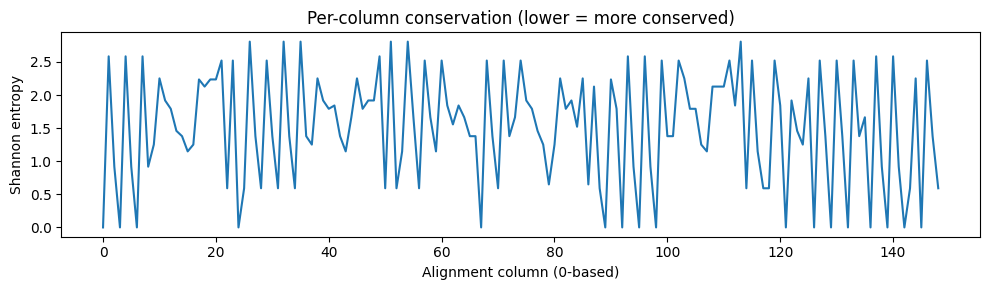

Saved /kaggle/working/figures/entropy.png


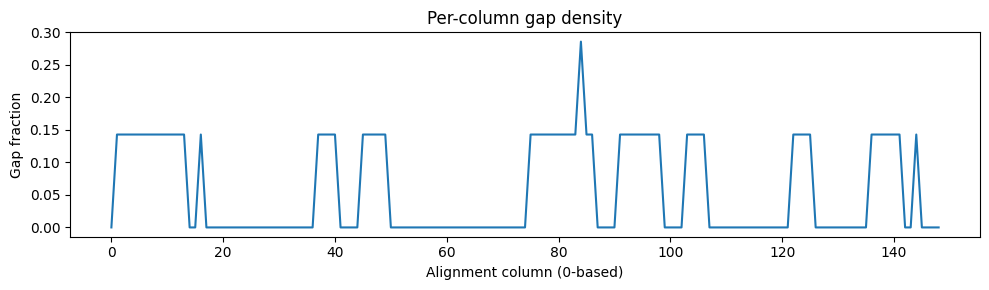

Saved /kaggle/working/figures/gap_density.png


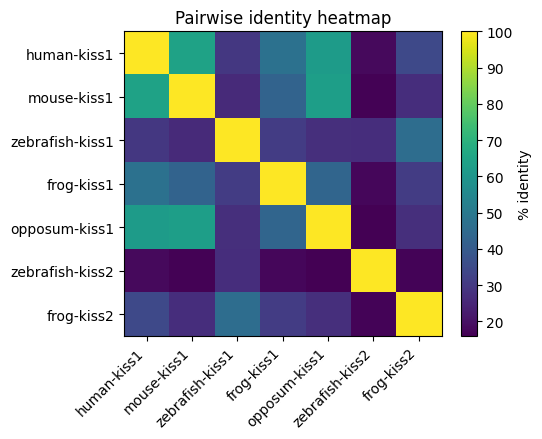

Saved /kaggle/working/figures/pid_heatmap.png
Saved /kaggle/working/tables/pairwise_identities.csv


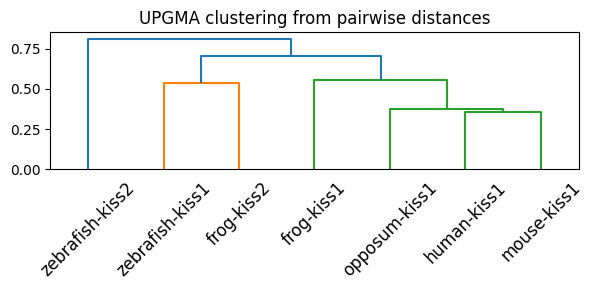

Saved /kaggle/working/figures/upgma_dendrogram.png
Saved /kaggle/working/results/reports/consensus.txt


,human-kiss1,mouse-kiss1,zebrafish-kiss1,frog-kiss1,opposum-kiss1,zebrafish-kiss2,frog-kiss2
human-kiss1,100.000000,64.335664,29.577465,47.222222,62.162162,18.095238,34.459459
mouse-kiss1,64.335664,100.000000,26.086957,42.857143,63.194444,16.666667,27.083333
zebrafish-kiss1,29.577465,26.086957,100.000000,30.935252,27.272727,27.000000,46.153846
frog-kiss1,47.222222,42.857143,30.935252,100.000000,43.448276,17.647059,31.034483
opposum-kiss1,62.162162,63.194444,27.272727,43.448276,100.000000,16.037736,27.516779
zebrafish-kiss2,18.095238,16.666667,27.000000,17.647059,16.037736,100.000000,16.981132
frog-kiss2,34.459459,27.083333,46.153846,31.034483,27.516779,16.981132,100.000000


Consensus (first 120 chars): MXXMXXMXXXXXXXXLXXXXXXMXMMXXMXXMXXMXXXXXXXXLXXXXXXMXMMXXMXXLXXXXXXXMXXMXXXXXXXXLXXXXXXMXMMXXMXXMXXMXXXXXXXXLXXXXXXMXMMMX


In [57]:
def show_then_save(path):
    if SHOW:
        plt.show()          # renders the current in-memory figure
    plt.savefig(path)        # then save to disk
    plt.close()
    print(f"Saved {path}")


# 1) Entropy
ents = np.array([shannon_entropy(aln[:,i]) for i in range(L)], float)
plt.figure(figsize=(10,3))
plt.plot(ents)
plt.xlabel("Alignment column (0-based)"); plt.ylabel("Shannon entropy")
plt.title("Per-column conservation (lower = more conserved)")
plt.tight_layout()
show_then_save("/kaggle/working/figures/entropy.png")

# 2) Gap density
gaps = np.array([gap_density(i) for i in range(L)], float)
plt.figure(figsize=(10,3))
plt.plot(gaps)
plt.xlabel("Alignment column (0-based)"); plt.ylabel("Gap fraction")
plt.title("Per-column gap density")
plt.tight_layout()
show_then_save("/kaggle/working/figures/gap_density.png")

# 3) Pairwise identities (heatmap + CSV)
M = np.zeros((n,n), float)
for i in range(n):
    for j in range(n):
        if i==j: M[i,i]=100.0
        elif j>i:
            M[i,j]=M[j,i]=pid(str(aln[i].seq), str(aln[j].seq))

import pandas as pd
pid_df = pd.DataFrame(M, index=ids, columns=ids)
pid_df.to_csv("/kaggle/working/tables/pairwise_identities.csv")

plt.figure(figsize=(5.5,4.5))
plt.imshow(M, aspect="auto")
plt.xticks(range(n), ids, rotation=45, ha="right"); plt.yticks(range(n), ids)
plt.colorbar(label="% identity")
plt.title("Pairwise identity heatmap")
plt.tight_layout()
show_then_save("/kaggle/working/figures/pid_heatmap.png")
print("Saved /kaggle/working/tables/pairwise_identities.csv")

# 4) UPGMA dendrogram (if SciPy available)
try:
    from scipy.cluster.hierarchy import linkage, dendrogram
    from scipy.spatial.distance import squareform
    D = 1.0 - (M/100.0)
    condensed = squareform(D, checks=False)
    Z = linkage(condensed, method="average")
    plt.figure(figsize=(6,3))
    dendrogram(Z, labels=ids, leaf_rotation=45)
    plt.title("UPGMA clustering from pairwise distances")
    plt.tight_layout()
    show_then_save("/kaggle/working/figures/upgma_dendrogram.png")
except Exception as e:
    print("SciPy dendrogram skipped:", e)

# 5) Consensus quick-look
summary = AlignInfo.SummaryInfo(aln)
consensus = summary.dumb_consensus(threshold=0.7, ambiguous='X')
# print(consensus)
open("/kaggle/working/results/reports/consensus.txt","w").write(str(consensus))
print("Saved /kaggle/working/results/reports/consensus.txt")

# # Optional: show the identity table inline (already in memory, not from file)
if SHOW:
    display(pid_df)
    print("Consensus (first 120 chars):", str(consensus)[:120])
